# Attention Architecture

Looks like transformer requires really large bptt, otherwise it seems to diverge

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

In [3]:
bs = 32
bptt = 128

In [4]:
# PATH=Path('data/wikitext-2-raw')
# data = TextLMDataBunch.load(PATH, cache_name='tmp_200', bs=bs, bptt=bptt)

In [5]:
PATH=Path('data/wikitext-2')
data = TextLMDataBunch.load(PATH, bs=bs, bptt=bptt)

In [6]:
# epoch = 1
# lr = 1e-3
momentum = (0.8,0.7)
weight_decay = 1.2e-6

In [7]:
vocab = data.train_ds.vocab
vocab_sz = len(vocab.itos); vocab_sz

33285

In [8]:
t = data.train_ds[0][0]
t.text[:50], t.data

('= Valkyria Chronicles III =', array([  17, 3915, 4426,  857,   17]))

In [9]:
ob = data.one_batch(); ob[1].shape

torch.Size([32, 153])

In [10]:
# data.show_batch()

In [11]:
from fastai.callbacks import RNNTrainer
class TransformerTrainer(LearnerCallback):
    def __init__(self, learn, bptt:int, adjust:bool=True):
        super().__init__(learn)
        self.bptt,self.adjust = bptt,adjust
        
    def on_train_begin(self, **kwargs):
        "IN LM, put the training dataloader `first` attribute to `True` to avoid OOM."
        if hasattr(self.learn.data.train_dl, 'first'):
            self.learn.data.first = True
            
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        position_ids = torch.arange(last_input.shape[-1], dtype=torch.long, device=last_input.device)
        position_ids = position_ids.unsqueeze(0).expand_as(last_input)
        target_ids = torch.arange(last_target.shape[-1], dtype=torch.long, device=last_target.device)
        target_ids = target_ids.unsqueeze(0).expand_as(last_target)
        
        ## STUPID TEST TO SEE IF IT CAN EVEN PREDICT ITSELF
#         return (last_input, position_ids, last_target, target_ids), last_target[:, :-1]
        return (last_input, position_ids, last_target, target_ids), last_target[:, 1:]
    
    def on_backward_begin(self, last_loss:Rank0Tensor, last_input:Tensor, **kwargs):
        "Adjusts the lr to the sequence length and applies AR and TAR to `last_loss`."
        if self.adjust: self.learn.opt.lr *= last_input.size(1) / self.bptt
        return last_loss


### Transformer Arch
Paper: https://arxiv.org/abs/1706.03762  
Inspiration: https://github.com/jadore801120/attention-is-all-you-need-pytorch

In [12]:
import transformer.Constants as Constants
# from dataset import TranslationDataset, paired_collate_fn
from transformer.Models import Transformer
from transformer.Optim import ScheduledOptim

In [13]:
transformer = Transformer(
    n_src_vocab=vocab_sz,
    n_tgt_vocab=vocab_sz,
    len_max_seq=data.bptt+data.max_len,
#     len_max_seq=opt.max_token_seq_len,
#     tgt_emb_prj_weight_sharing=False,
#     emb_src_tgt_weight_sharing=False,
#     d_k=opt.d_k,
#     d_v=opt.d_v,
#     d_model=opt.d_model,
#     d_word_vec=opt.d_word_vec,
#     d_inner=opt.d_inner_hid,
#     n_layers=opt.n_layers,
#     n_head=opt.n_head,
#     dropout=opt.dropout
)

### Create Language learner

Currently model is completely diverging

In [14]:
# transformer = Transformer(
#     n_src_vocab=vocab_sz,
#     n_tgt_vocab=vocab_sz,
#     len_max_seq=data.bptt+data.max_len,
#     tgt_emb_prj_weight_sharing=False,
#     emb_src_tgt_weight_sharing=False,
    
#     n_layers=4,
#     n_head=4,
#     d_k=16,
#     d_v=16,
#     d_model=64,
#     d_inner=256,
#     d_word_vec=64
# )

In [15]:
learn = LanguageLearner(data, transformer, 
                        bptt=bptt, clip=0.1)




In [16]:
rt = learn.callbacks[0]
learn.callbacks = [
    TransformerTrainer(learn, bptt=rt.bptt, adjust=rt.adjust)
]

In [17]:
learn = learn.to_fp16(loss_scale=256)

In [18]:
learn.unfreeze()

In [19]:
learn.lr_find(num_it=500)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


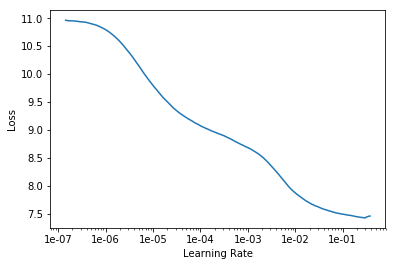

In [20]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(22, 1e-3, moms=(0.7,0.5))

epoch,train_loss,valid_loss,accuracy
1,8.070165,7.569767,0.111516
2,7.132996,6.710927,0.126433


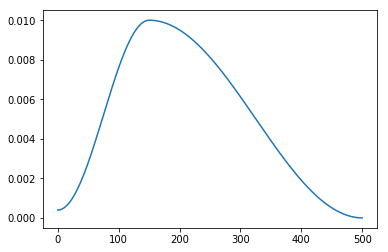

In [22]:
learn.recorder.plot_lr()

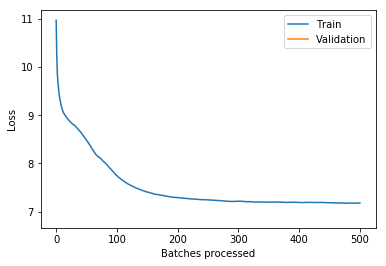

In [23]:
learn.recorder.plot_losses()

In [17]:
learn.save('transformer_run1_1en4');